In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [6]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [7]:
from __future__ import print_function
from numpy import *
from scipy import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import reload
import matplotlib.patches as patches

import netCDF4 as nc
import numpy as np
import scipy as sp

import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

# matplotlib.use('Agg')
# plt.style.use('seaborn-whitegrid')
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs

from scipy import optimize
import arrow
import gsw
import pandas as pd
%matplotlib inline

## METHOD SUMMARY: Essentially, we ask: how old is this water? We get a proxy for how old the water is via how dense it is. Then we ask: What atmospheric CO2 did it see when it was last at the surface? How different is that CO2 from preindustrial CO2? This is the CO2 anthropogenic intrusion. So, surface water will have a big intrusion, deep water won't. We then subtract the intrusion (in pco2) from the mocsy-calculated pco2 of the present-day boundary conditions to get preindustrial pco2. THEN we use the same TA and all other conditions, with this different pco2, to calculate the preindustrial DIC.

## Part 1: Use  isopycnal vs ventilation age relationship to get age of watermass estimate, then use co2 levels at that age to get identity of co2 intrusion



    1) plot age of water as fxn of isopycnal - use scipy-optimize...
    2) plot intrusion of pco2 as fxn of age...what is the 'correct' reference here?
    
problem - the age of water as a function of isopycnal gets very exponential very quickly- an isopycnal of 25.7 has an age of ~320 years. 


##### atmospheric CO2 - used co2levels.org data sources, 
###### smoothed yearly product (ice core 1832-1959, maunaloa 1959-pres)

    1832- 1958: https://cdiac.ess-dive.lbl.gov/ftp/trends/co2/lawdome.combined.dat
    1959 - pres: https://www.co2levels.org/#sources




### PPM CO2 from 1832-2018, using above sources, and code to look up atmco2 for a given year from 1832-2018

In [8]:
co2_rec = pd.read_csv('lawdome_maunaloa.csv') 


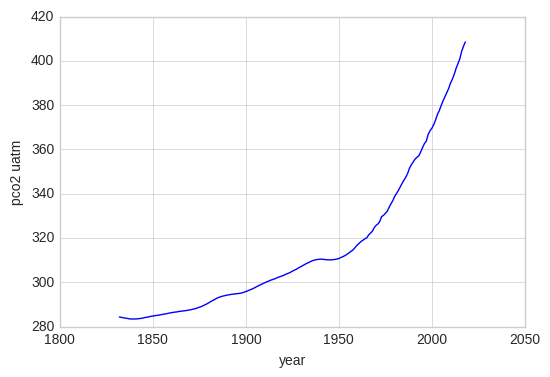

In [9]:
plt.plot(co2_rec['YEAR'],co2_rec['PPMCO2'])
plt.ylabel('pco2 uatm')
plt.xlabel('year')

In [10]:
co2_rec = pd.read_csv('lawdome_maunaloa.csv') 
def co2_from_year(year):
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #print('year > 2018, using value for 2018')
        
    if whole_year <= 1832:
        whole_year = 1832
        #print('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2

In [11]:
#test
ty = 1000
tco2 = co2_from_year(ty)
print('year: '+str(ty) +', pco2: '+str(tco2))
ty = 1900
tco2 = co2_from_year(ty)
print('year: '+str(ty) +', pco2: '+str(tco2))
ty = 2004
tco2 = co2_from_year(ty)
print('year: '+str(ty) +', pco2: '+str(tco2))

year: 1000, pco2: 284.3
year: 1900, pco2: 295.8
year: 2004, pco2: 377.52


## from Tetjana's plot, define pycnals and ventilation age, use scipy curve_fit to make a fxn of ventilation time/year last at surface vs pycnal, use above code to find atm co2 when pycnal was last at surface

In [12]:

pycnal = np.array([24.4, 25.15, 25.4, 25.6])
pycnal_age = np.array([0,1,10,100])

def test_func(x, a, b, c):
    return a * np.exp(-b * (25.15-x)) + c

params, params_covariance = optimize.curve_fit(test_func, pycnal, pycnal_age,
                                               p0=[1, -0.05, -25.15])
params0 = params[0]
params1 = params[1]
params2 = params[2]
print(params0)
print(params1)
print(params2)

pycnal_forfunc =np.arange(24.4,27,0.05)
pycnal_age_fromfunc = params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2
pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)

for i in range(0,len(pycnal_original_co2)):
    ty = pycnal_last_at_surface[i]
    tco2 = co2_from_year(ty)
    pycnal_original_co2[i] = tco2
    
    
pycnal_intrusion = 409 - pycnal_original_co2


0.5406570488955575
11.595484591464743
0.2153367515219747


## ventilation age as a fxn of isopycnal, station P04, km 220

## we see that 25.4-25.7 is the critical interval where age matters.

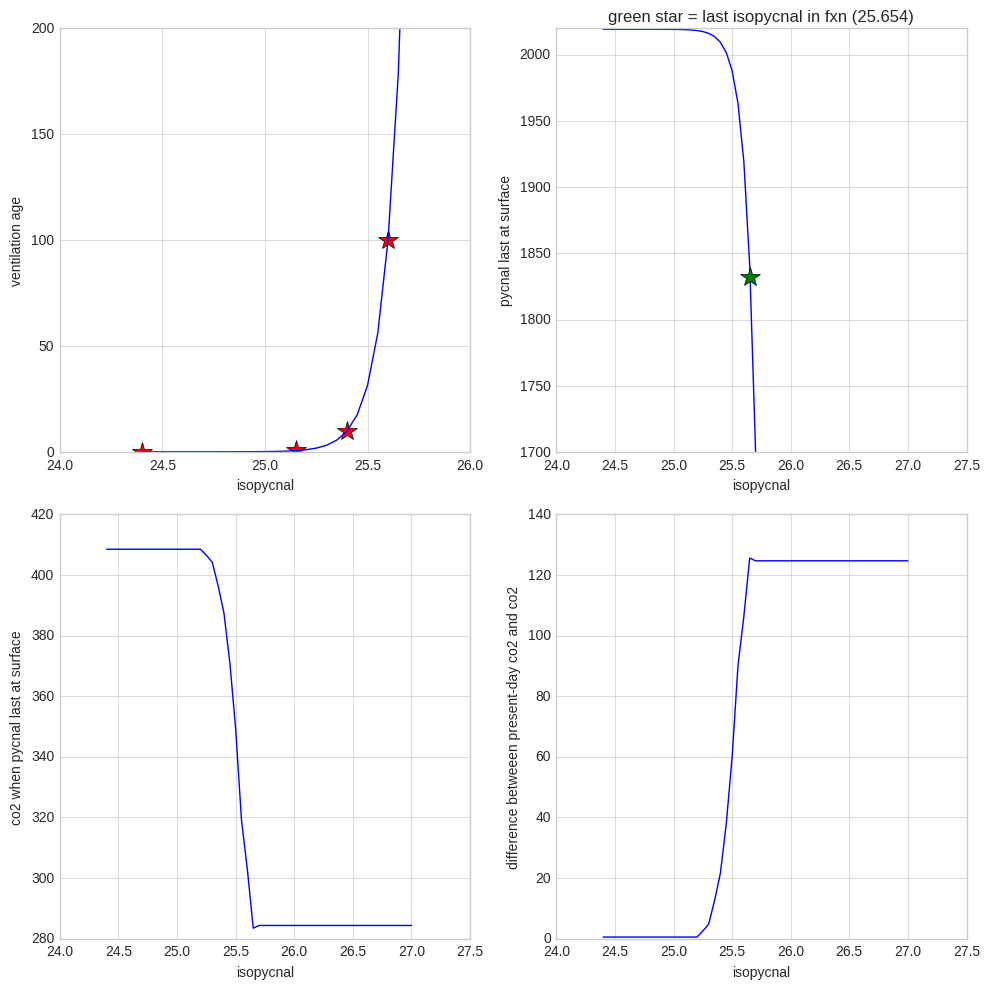

In [13]:
fig = plt.figure(figsize=(10,10))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,2,i)
        ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_age_fromfunc)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('ventilation age')
        ax.set_xlim([24.0,26.0])
        ax.set_ylim([0,200])
        

    if i == 2:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_last_at_surface)
        ax.plot(25.654,1832.1497986658724,'g*', markersize = 15)
        ax.set_ylim([1700,2020])
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('pycnal last at surface')
        ax.set_title('green star = last isopycnal in fxn (25.654)')

    if i == 3:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_original_co2)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('co2 when pycnal last at surface')


    if i == 4:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_intrusion)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('difference betweeen present-day co2 and co2')

   
        
plt.tight_layout()

In [14]:
pycnal_forfunc2 = 24.4
pycnal_age_fromfunc = params[0] *np.exp(-params[1]*(25.15-pycnal_forfunc2))+params[2]
pycnal_last_at_surface = 2019 - pycnal_age_fromfunc
print('minimum pycnal for function: ', pycnal_forfunc2)
print('last at surface:', pycnal_last_at_surface)
pycnal_forfunc2 = 25.654
pycnal_age_fromfunc = params[0] *np.exp(-params[1]*(25.15-pycnal_forfunc2))+params[2]
pycnal_last_at_surface = 2019 - pycnal_age_fromfunc
print('Max pycnal for function: ', pycnal_forfunc2)
print('last at surface:', pycnal_last_at_surface)

minimum pycnal for function:  24.4
last at surface: 2018.7845728771551
Max pycnal for function:  25.654
last at surface: 1832.1497986658724


In [15]:
test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m06d01.nc')
zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
potdens = gsw.sigma0(sal,temp)
potdens_mask = np.copy(potdens)
potdens_mask[potdens>24.4] = 1
potdens_mask[potdens<=24.4] = -1

DIC = test_LO['DIC'][0,:,0,:]
TA = test_LO['TA'][0,:,0,:]

depth_this = np.zeros_like(TA)

for i in range(0,950):
    depth_this[:,i] = zlevels

In [16]:

pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-potdens))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)
np.shape(pycnal_original_co2)
for i in range(0,40):
    for j in range(0,950):
        ty = pycnal_last_at_surface[i,j]
        tco2 = co2_from_year(ty)
        pycnal_original_co2[i,j] = tco2


pycnal_intrusion = 409 - pycnal_original_co2

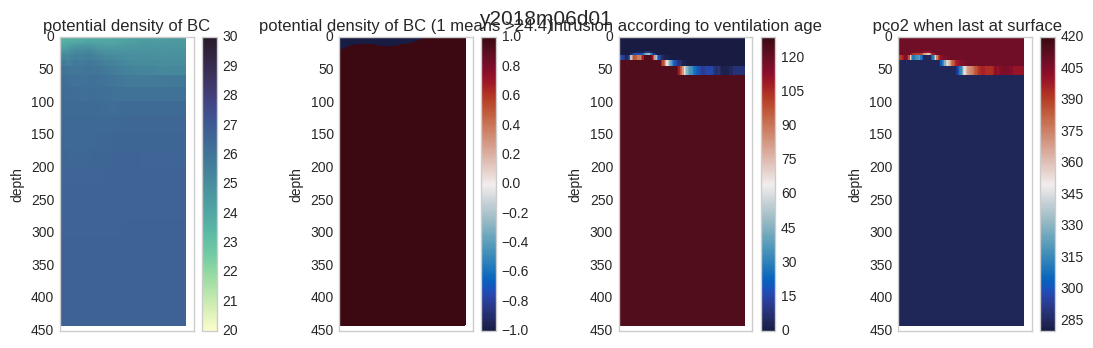

In [17]:
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (potdens)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=20, vmax=30)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (potdens_mask)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-1, vmax=1)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC (1 means >24.4)') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (pycnal_intrusion)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=0, vmax=129)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('intrusion according to ventilation age') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])   
        
    if i == 4:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (pycnal_original_co2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=280, vmax=420)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title(' pco2 when last at surface') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])    


        
plt.suptitle('y2018m06d01', fontsize = 15)
plt.tight_layout()

In [18]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):

    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]


    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1)
    OmAr = OmegaA.reshape(size_0,size_1)
    pco2r = pco2.reshape(size_0,size_1)
    
    return pHr, OmAr, pco2r

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def find_DIC_corresp_to_pco2(tsal, ttemp, tpco2, tta, pres_atm, depth_this):
    
    steps = 10000
    tsal_r = np.zeros([steps])
    tsal_r[:] = tsal
    ttemp_r = np.zeros([steps])
    ttemp_r[:] = ttemp
    tta_r = np.zeros([steps])
    tta_r[:] = tta * 1e-3
    tpres_r = np.zeros([steps])
    tpres_r[:] = pres_atm
    depth_r = np.zeros([steps])
    depth_r[:] = depth_this
    tzero = np.zeros([steps])

    end_d = 2400
    start_d = 600
    intvl = (end_d - start_d)/steps
    tdic_r = np.arange(start_d,end_d-0.1,intvl) * 1e-3
    
    response_tup = mocsy.mvars(temp=ttemp_r, sal=tsal_r, alk=tta_r, dic=tdic_r, 
                       sil=tzero, phos=tzero, patm=tpres_r, depth=depth_r, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
    
    diffmat = pco2 - tpco2
    idx, ans = find_nearest( diffmat,0 )
    
    if ans> 2:
        print('Danger, pco2 found >2 uatm from pco2 given')
#     print(idx)
#     print('difference between real pco2 and pco2 from calc. dic: ',ans)
#     print('DIC found this way:', tdic_r[idx]*1e3)
    fin_dic = tdic_r[idx]*1e3
    
    return fin_dic
    


## Steps to creating a BC file with preindustrial DIC

#### 1) open a boundary condition file and visualize DIC and POT DENS

#### 2) find and visualize present-day PCO2 

#### 3) find and visualize intrusion from pot-dens

#### 4) find supposed preindustrial PCO2 by subtracting intrusion from present-day PCO2

#### 5) calculate DIC from said preindustrial PCO2, present-day TA

#### 5b) write a new boundary condition file

In [19]:
##1) 

test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
potdens = gsw.sigma0(sal,temp)
potdens_mask = np.copy(potdens)
potdens_mask[potdens>24.4] = 1
potdens_mask[potdens<=24.4] = -1

zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
DIC = test_LO['DIC'][0,:,0,:]
TA = test_LO['TA'][0,:,0,:]

depth_this = np.zeros_like(TA)

for i in range(0,950):
    depth_this[:,i] = zlevels

pHr, OmAr, pco2r = oned_moxy(sal, temp, DIC, TA, 1, depth_this)

pco2_resh = pco2r.reshape(40,950)


## 1) open a boundary condition file and visualize DIC and POT DENS

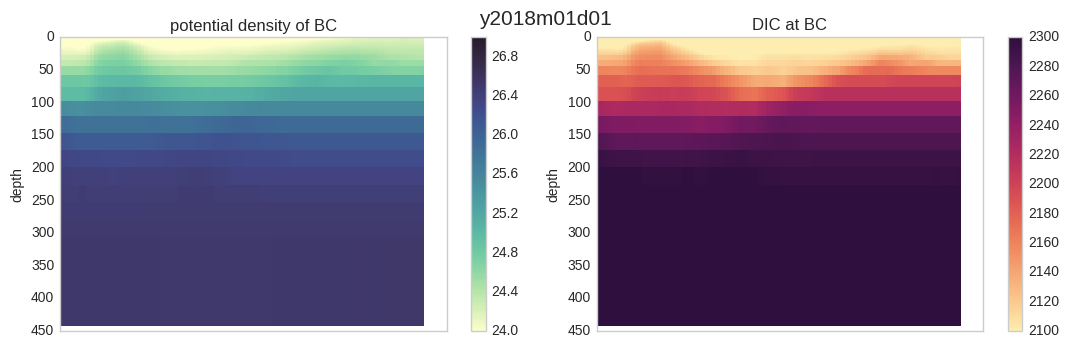

In [20]:
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (potdens)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=24, vmax=27)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (DIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.matter
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2100, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('DIC at BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])

plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

## 2) find and visualize present-day PCO2 

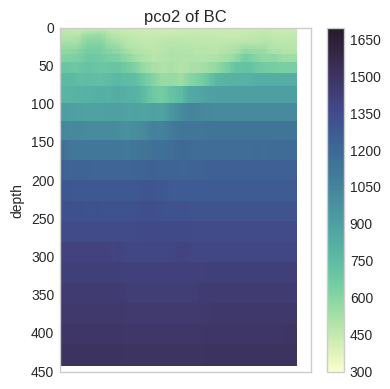

In [21]:
pco2_resh

fig = plt.figure(figsize=(4,4))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,1,i)
        section_slice = np.arange(0, 95)
        sd = (pco2_resh)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=300, vmax=1700)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        

#plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

In [22]:
pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-potdens))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)
np.shape(pycnal_original_co2)
for i in range(0,40):
    for j in range(0,950):
        ty = pycnal_last_at_surface[i,j]
        tco2 = co2_from_year(ty)
        pycnal_original_co2[i,j] = tco2


pycnal_intrusion =  pycnal_original_co2 - 284

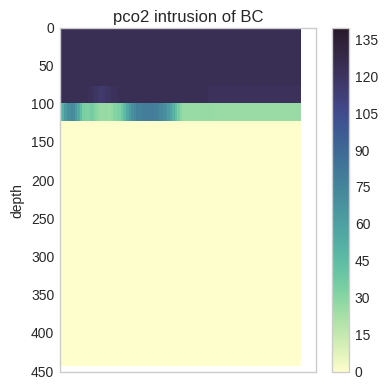

In [23]:
pco2_resh

fig = plt.figure(figsize=(4,4))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,1,i)
        section_slice = np.arange(0, 95)
        sd = (pycnal_intrusion)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=0, vmax=140)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 intrusion of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        

#plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

In [24]:
preind_pco2 = pco2_resh - pycnal_intrusion

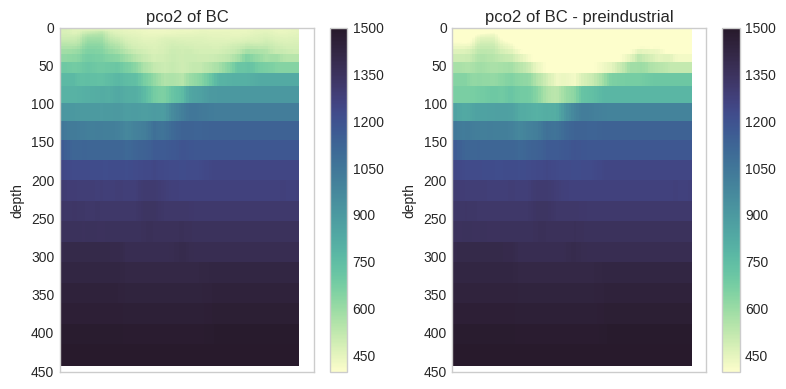

In [25]:
pco2_resh

fig = plt.figure(figsize=(8,4))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (pco2_resh)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=400, vmax=1500)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (preind_pco2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=400, vmax=1500)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 of BC - preindustrial') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
#plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

In [26]:
# this code can calculate preindustrial DIC
#


# preind_dic = np.zeros_like(DIC)
# preind_dic_r = np.ravel(preind_dic)
# pco2r_preind_r = np.ravel(preind_pco2)
# depth_r = np.ravel(depth_this)
# sal_r = np.ravel(sal)
# temp_r = np.ravel(temp)
# DIC_r = np.ravel(DIC)
# TA_r = np.ravel(TA)
# for i in range(0,len(depth_r)):
#     if i%950 == 0:
#         print(i)
#     t_dic = find_DIC_corresp_to_pco2(sal_r[i], temp_r[i], pco2r_preind_r[i], TA_r[i], 1, depth_r[i])
#     preind_dic_r[i] = t_dic

# preind_dic_fin = preind_dic_r.reshape(40,950)

## how much extra DIC does this translate to? (Jan 1st, one example)

In [29]:

preind_nc = nc.Dataset('//data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/PI_BOUND_COND/preind_DIC/calculated_new_DIC_corrected'
                       + '/LO_corrected_y2015m01d01_preind_DIC.nc')

presday_nc = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_'+
                       'y2015m01d01.nc')

preind_nc_DIC = preind_nc['preindustrial_DIC']['preind_dic']
presday_nc_DIC = presday_nc['DIC']
# preind_nc_TA = preind_nc['TA']
# presday_nc_TA = presday_nc['TA']

for i in range(0,10):
    preind_DIC_res = np.zeros([40,10,95])
    preind_DIC_res[:,i,:] = preind_nc_DIC[:,i*95:(i+1)*95]
    preind_DIC_res[preind_DIC_res ==0 ] = nan
    preind_mean_DIC = np.nanmean(preind_DIC_res,axis = 1)
    presday_DIC_res = np.zeros([40,10,95])
    presday_DIC_res[:,i,:] = presday_nc_DIC[0,:,0,i*95:(i+1)*95]
    presday_DIC_res[presday_DIC_res ==0 ] = nan
    presday_mean_DIC = np.nanmean(presday_DIC_res,axis = 1)

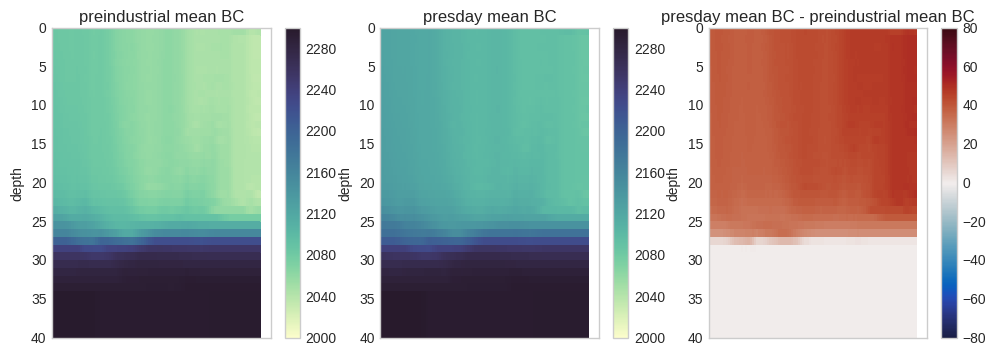

In [30]:
fig = plt.figure(figsize=(12,4))
nop = 3
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,3,i)
        tcmap = cm.cm.deep
        cmap = tcmap
        tplt = preind_mean_DIC
        mesh = ax.pcolormesh(tplt, cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('preindustrial mean BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,3,i)
        tcmap = cm.cm.deep
        cmap = tcmap
        tplt = presday_mean_DIC
        mesh = ax.pcolormesh(tplt, cmap = tcmap, vmin=2000, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('presday mean BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(1,3,i)
        tcmap = cm.cm.balance
        cmap = tcmap
        tplt = presday_mean_DIC - preind_mean_DIC
        mesh = ax.pcolormesh(tplt, cmap = tcmap, vmin=-80, vmax=80)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('presday mean BC - preindustrial mean BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])

## average monthly extra DIC...


In [31]:
#this script takes the preindustrial boundary condition values 
#calculated in preind_DIC_BC_loop2 and puts them in the right format
#to mimc the LO boundary conditions.

def preind_dic_ncmaker(startind, endind, year):
#1 open given boundary conditions file and findpco2 and potential density 
    daymon = [31,28,31,30,31,30,31,31,30,31,30,31]
    daymon_LY = [31,29,31,30,31,30,31,31,30,31,30,31]

    year_ar = []
    noday = 365
    if year == 2016:
        t_daymon = daymon_LY
        noday = 366
    else:
        t_daymon = daymon

    for m in range(1,13):
        if m>=10:
            tm = str(m)
        if m<10:
            tm = '0' + str(m)
        for d in range(1,t_daymon[m-1]+1):
            if d>=10:
                td = str(d)
            if d<10:
                td = '0' + str(d)

            tstr = 'y' + str(year) + 'm' + tm + 'd' + td
            year_ar.append(tstr)
                            
    for ind in range(startind,endind):
        print(year_ar[ind])
        dsin = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_' + year_ar[ind] +'.nc')
        preind = nc.Dataset('./preind_DIC/LO_corrected_' +year_ar[ind] + '_preind_DIC.nc')
        t_DIC = preind['preindustrial_DIC']['preind_dic'][:]
        #print(t_DIC)
        DIC_res = np.zeros([1,40,1,950])
        DIC_res[0,:,0,:] = t_DIC
        
        ncname = './preind_DIC/PREIND_BC_corrected_v201905_'  + year_ar[ind] +'.nc'
        dsout = nc.Dataset(ncname, "w", format="NETCDF4")
        #Copy dimensions
        for dname, the_dim in dsin.dimensions.items():
            print(dname)
            print(len(the_dim))
            dsout.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
        # Copy variables
        for v_name, varin in dsin.variables.items():
            outVar = dsout.createVariable(v_name, varin.datatype, varin.dimensions)
            print(varin.datatype)

            # Copy variable attributes
            outVar.setncatts({k: varin.getncattr(k) for k in varin.ncattrs()})

            outVar[:] = varin[:]

        dsout['DIC'][:] = DIC_res[:]
        dsout.close()

In [32]:
# preind_dic_ncmaker(0, 365, 2015)

In [33]:
year_preind_mean = np.zeros([365,40,95])
year_presday_mean = np.zeros([365,40,95])

In [34]:
year_ar = []
year = 2015
noday = 365
daymon = [31,28,31,30,31,30,31,31,30,31,30,31]
daymon_LY = [31,29,31,30,31,30,31,31,30,31,30,31]

if year == 2016:
    t_daymon = daymon_LY
    noday = 366
else:
    t_daymon = daymon

for m in range(1,13):
    if m>=10:
        tm = str(m)
    if m<10:
        tm = '0' + str(m)
    for d in range(1,t_daymon[m-1]+1):
        if d>=10:
            td = str(d)
        if d<10:
            td = '0' + str(d)

        tstr = 'y' + str(year) + 'm' + tm + 'd' + td
        year_ar.append(tstr)

In [35]:
for d in range(0,365):
    preind_nc = nc.Dataset('/data/tjarniko/MEOPAR/analysis-tereza/'+
                      'notebooks/carbon_dev/BASE_RUN/CLEAN/'+
                      'preind_DIC/ncs_copied_from_LO_with_new_DIC_values_CORRECTED/PREIND_BC_corrected_v201905_' + year_ar[d] +'.nc')

    presday_nc = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_' + year_ar[d] +'.nc')

    preind_nc_DIC = preind_nc['DIC']
    presday_nc_DIC = presday_nc['DIC']
    preind_nc_TA = preind_nc['TA']
    presday_nc_TA = presday_nc['TA']

    for i in range(0,10):
        preind_DIC_res = np.zeros([40,10,95])
        preind_DIC_res[:,i,:] = preind_nc_DIC[0,:,0,i*95:(i+1)*95]
        preind_DIC_res[preind_DIC_res ==0 ] = nan
        preind_mean_DIC = np.nanmean(preind_DIC_res,axis = 1)
        presday_DIC_res = np.zeros([40,10,95])
        presday_DIC_res[:,i,:] = presday_nc_DIC[0,:,0,i*95:(i+1)*95]
        presday_DIC_res[presday_DIC_res ==0 ] = nan
        presday_mean_DIC = np.nanmean(presday_DIC_res,axis = 1)
        
    year_preind_mean[d,:,:] = preind_mean_DIC
    year_presday_mean[d,:,:] = presday_mean_DIC


OSError: No such file or directory

## Average monthly DIC difference, pres-day-preindustrial

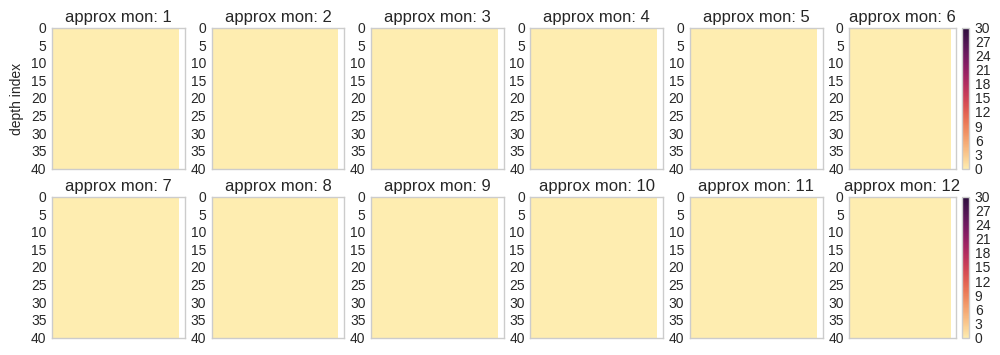

In [36]:
fig = plt.figure(figsize=(12,4))
nop = 12
for i in range(1,nop+1):

    ax = fig.add_subplot(2,6,i)
    tcmap = cm.cm.matter
    cmap = tcmap
    preind_monmean = np.nanmean(year_preind_mean[(i-1)*30:(i)*30,:,:], axis = 0)
    presday_monmean = np.nanmean(year_presday_mean[(i-1)*30:(i)*30,:,:], axis = 0)
    mesh = ax.pcolormesh(presday_monmean - preind_monmean, cmap = tcmap, vmin=0, vmax=30)
    if i ==6:
        cbar = fig.colorbar(mesh, ax=ax)
    if i ==12:
        cbar = fig.colorbar(mesh, ax=ax)
    if i ==1:
        ax.set_ylabel('depth index')
    ax.invert_yaxis()
    land_colour = 'slategrey'
    cmap.set_bad(land_colour)
    plt.title('approx mon: ' + str(i)) 

    ax.set_xticklabels([])
#
#plt.tight_layout()       



## JS conditions

In [ ]:
preind_nc = nc.Dataset('/data/tjarniko/MEOPAR/analysis-tereza/'+
                  'notebooks/carbon_dev/BASE_RUN/CLEAN/'+
                  'preind_DIC/JS_corrected_preind_DIC.nc')

presday_nc = nc.Dataset('/data/tjarniko/MEOPAR/tracers/' +
                      'north/Dosser_north_TEOS10_DICTA.nc')

In [ ]:
preind_DIC = preind_nc['preindustrial_DIC']['preind_dic'][:]
presday_DIC = presday_nc['DIC']

monthly_pi_DIC = np.nanmean(preind_DIC,axis = 2)
monthly_pres_DIC = np.nanmean(presday_DIC,axis = 2)


In [ ]:
fig = plt.figure(figsize=(12,4))
nop = 12
for i in range(1,nop+1):

    ax = fig.add_subplot(2,6,i)
    tcmap = cm.cm.matter
    cmap = tcmap
    presday_monmean = monthly_pres_DIC[i-1,:,:]
    preind_monmean = monthly_pi_DIC[i-1,:,:]
    mesh = ax.pcolormesh(presday_monmean - preind_monmean, cmap = tcmap, vmin=0, vmax=50)
    if i ==6:
        cbar = fig.colorbar(mesh, ax=ax)
    if i ==12:
        cbar = fig.colorbar(mesh, ax=ax)
    if i ==1:
        ax.set_ylabel('depth index')
    ax.invert_yaxis()
    land_colour = 'slategrey'
    cmap.set_bad(land_colour)
    plt.title('approx mon: ' + str(i)) 

    ax.set_xticklabels([])
#
#plt.tight_layout()       



In [ ]:
dsin = nc.Dataset('/data/tjarniko/MEOPAR/tracers/north/Dosser_north_TEOS10_DICTA.nc')
preind = nc.Dataset('/data/tjarniko/MEOPAR/analysis-tereza/'+
                  'notebooks/carbon_dev/BASE_RUN/CLEAN/'+
                  'preind_DIC/JS_corrected_preind_DIC.nc')

t_DIC = preind['preindustrial_DIC']['preind_dic'][:]
#print(t_DIC)
# DIC_res = np.zeros([1,40,1,950])
# DIC_res[0,:,0,:] = t_DIC

ncname = './preind_DIC/PREIND_BC_corrected_JS.nc'
dsout = nc.Dataset(ncname, "w", format="NETCDF4")
#Copy dimensions
for dname, the_dim in dsin.dimensions.items():
    print(dname)
    print(len(the_dim))
    dsout.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
# Copy variables
for v_name, varin in dsin.variables.items():
    outVar = dsout.createVariable(v_name, varin.datatype, varin.dimensions)
    print(varin.datatype)

    # Copy variable attributes
    outVar.setncatts({k: varin.getncattr(k) for k in varin.ncattrs()})

    outVar[:] = varin[:]

dsout['DIC'][:] = t_DIC[:]
dsout.close()